<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_BiLSTM_remove_stopwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

     |████████████████████████████████| 55 kB 1.3 MB/s 
     |████████████████████████████████| 8.2 MB 10.8 MB/s 


In [2]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [3]:
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU_remove_stopwords.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU_remove_stopwords.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [4]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
3815,скорее один пост обойтись женщина достижение к...,0
5656,захуярить сотряса быть тупой свой первый сотря...,1
5176,найтись девушка спасибо большой,0
3046,шаболда уровень легалпорно,1
12242,дочитать поезд норильск далёкий стать,0
5785,нормально труд набирать,0
10503,отсутствие дополнительный расход выгода,0
2214,хуй никто волновать иметь ввиду дядя слишком с...,1
11854,зимний резина бывать вес обычный неплохо справ...,0
7002,дополнение весь техника кроме мотоцикл багга а...,0


In [5]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 5943
min : 2
mean : 127.40542980141647


max:  717
min:  1
mean:  16.417372587140676


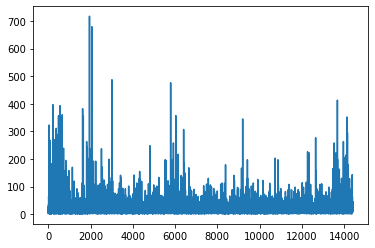

In [6]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [7]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)

In [9]:
X_train.shape

(11521,)

In [10]:
type(X_train)

numpy.ndarray

In [11]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [12]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [13]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [14]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))

In [15]:
sequence_length

18

In [16]:
navec.get('<unk>').shape[0]

300

In [17]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))


In [18]:
X_train.shape

(11521, 18, 300)

**Build RNN model**

Model: "Glove-Navec_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_2 (Spatia  (None, 18, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 18, 512)          1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_2 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                

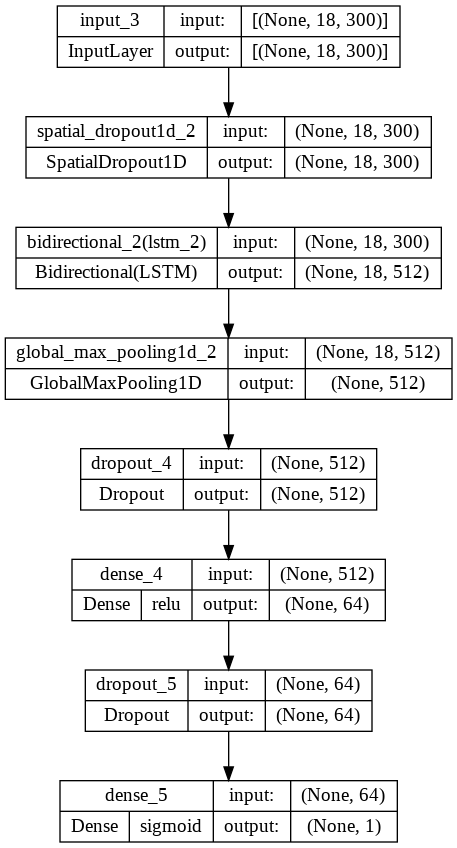

In [48]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
SPLIT = 0.2
EPOCHS = 50
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_BiLSTM'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [85]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=SPLIT,
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/50
18/18 [==============================] - 1s 78ms/step - loss: 0.0376 - tp: 3026.0000 - fp: 77.0000 - tn: 6083.0000 - fn: 30.0000 - accuracy: 0.9884 - precision: 0.9752 - recall: 0.9902 - auc: 0.9981 - prc: 0.9957 - val_loss: 0.7364 - val_tp: 672.0000 - val_fp: 199.0000 - val_tn: 1317.0000 - val_fn: 117.0000 - val_accuracy: 0.8629 - val_precision: 0.7715 - val_recall: 0.8517 - val_auc: 0.9082 - val_prc: 0.8156
Epoch 2/50
18/18 [==============================] - 1s 71ms/step - loss: 0.0501 - tp: 3006.0000 - fp: 125.0000 - tn: 6035.0000 - fn: 50.0000 - accuracy: 0.9810 - precision: 0.9601 - recall: 0.9836 - auc: 0.9981 - prc: 0.9960 - val_loss: 0.6478 - val_tp: 658.0000 - val_fp: 171.0000 - val_tn: 1345.0000 - val_fn: 131.0000 - val_accuracy: 0.8690 - val_precision: 0.7937 - val_recall: 0.8340 - val_auc: 0.9135 - val_prc: 0.8368
Epoch 3/50
18/18 [==============================] - 1s 71ms/step - loss: 0.0378 - tp: 3013.0000 - fp: 100.0000 - tn: 6060.0000 - fn: 43.0000 - accuracy

**Save model**

In [86]:
model.save(MODEL_NAME)

In [87]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 1s 14ms/step


In [88]:
pred

array([9.9997437e-01, 9.9997807e-01, 3.1567097e-04, ..., 3.3794556e-06,
       9.8235148e-01, 1.7990513e-03], dtype=float32)

In [89]:
pred

array([9.9997437e-01, 9.9997807e-01, 3.1567097e-04, ..., 3.3794556e-06,
       9.8235148e-01, 1.7990513e-03], dtype=float32)

In [90]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

In [91]:
pred

array([1, 1, 0, ..., 0, 1, 0])

In [92]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 88.30 %
Recall: 84.36 %
Precision: 81.76 %
F1-score: 83.04 % 

True Negatives:  1719
False Positives:  184
False Negatives:  153
True Positives:  825


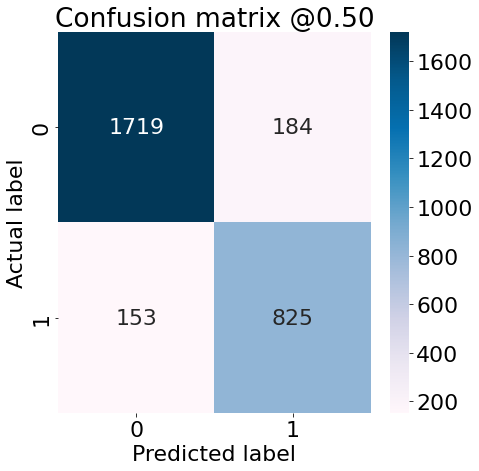

In [93]:
plot_cm(y_test, pred)

In [94]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

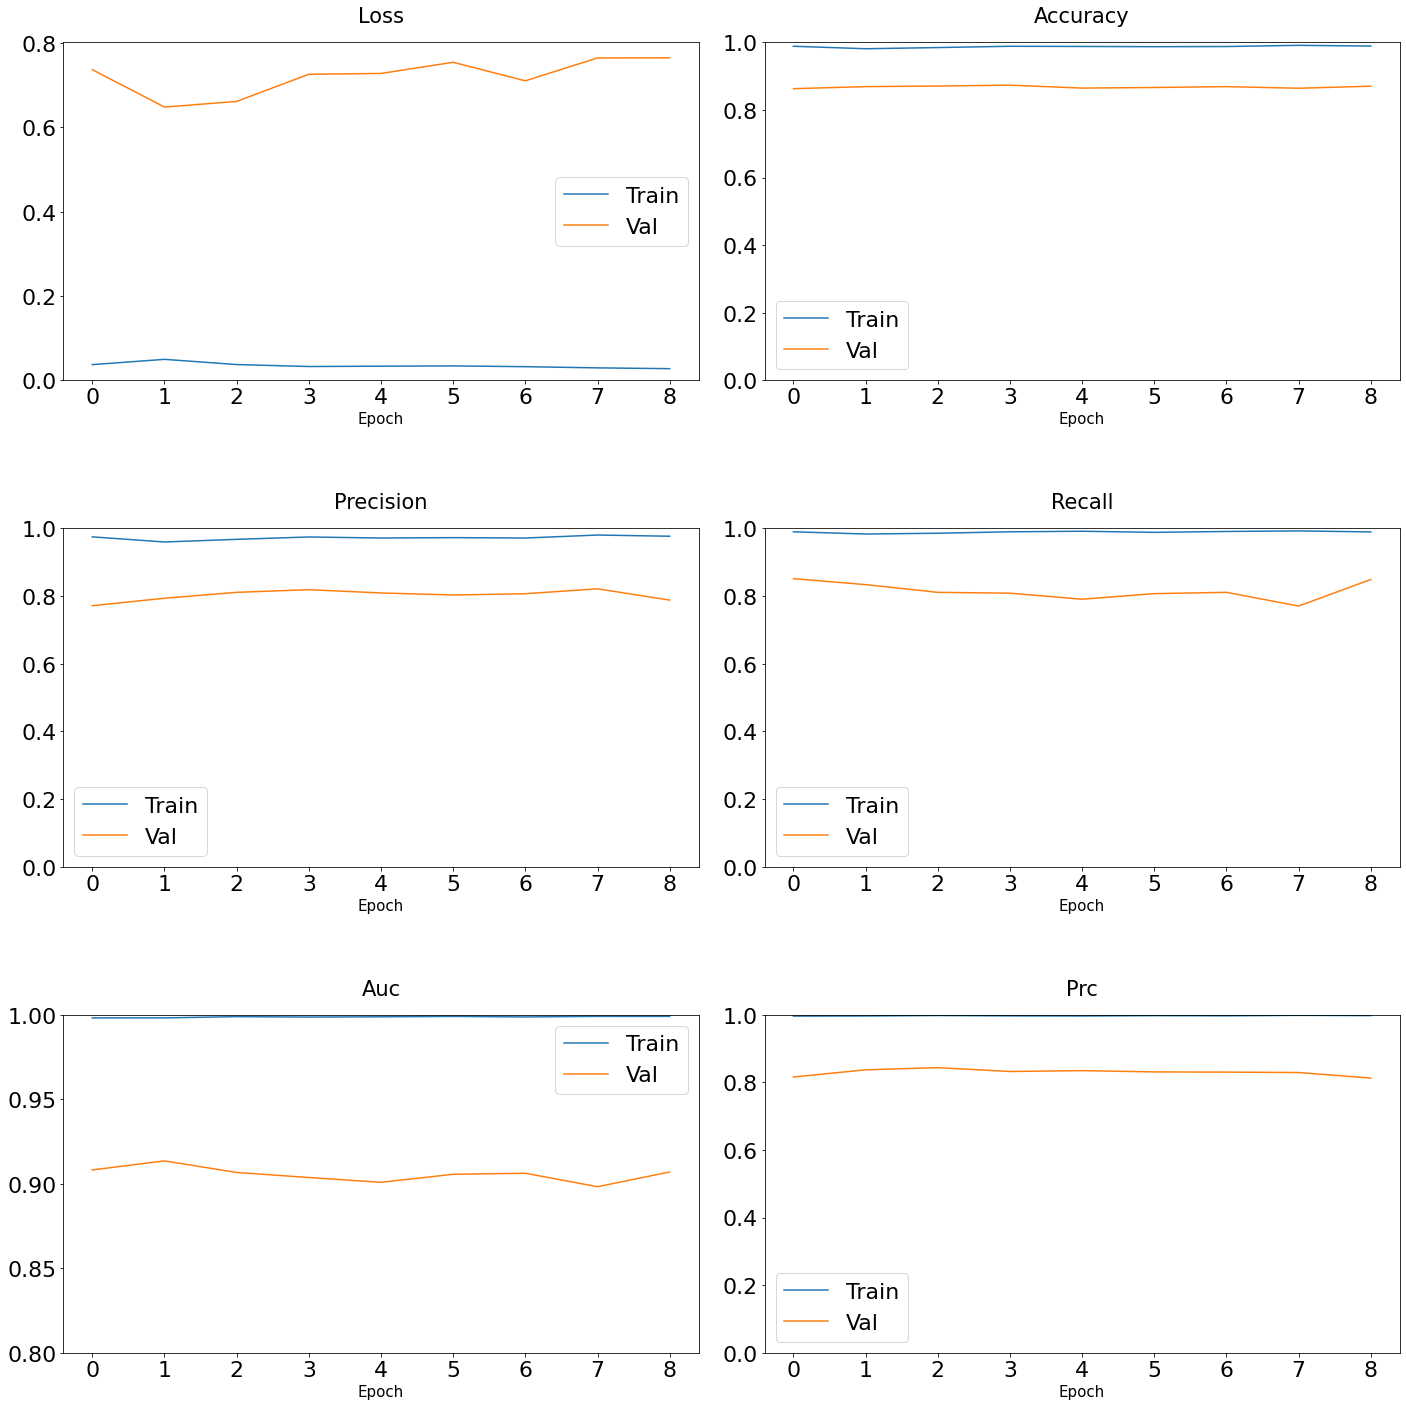

In [95]:
plot_metrics(history)

**Отобразим ROC - кривую**

91/91 [==============================] - 1s 14ms/step
: ROC AUC=0.941


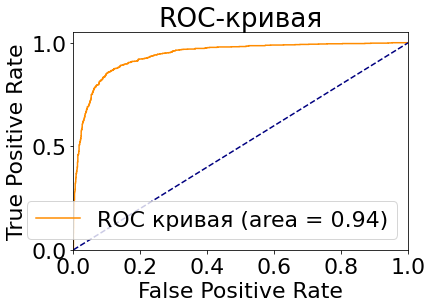

In [96]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = model.predict(X_test).flatten()
threshold =0.5
pred = np.where(pred<threshold,0,1)
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()